# Import des fonctions nécessaires :

In [8]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import itertools # Pour créer des iterateurs
import time

import matplotlib.pyplot as plt  # Pour l'affichage d'images
from matplotlib import cm # Pour importer de nouvelles cartes de couleur

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn import metrics

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline

# Load the data, the model and prepare samples to evaluate the model

In [2]:
# Define the data filepath and the model filepath
csv_5fam = "/Users/Adrien/DataScientist/projet_Mushroom/reduced_dataset_5_families.csv"
model_path = "/Users/Adrien/DataScientist/projet_Mushroom/models_GPU_20210620/model_vgg19_GPU_20210620.h5"
# Load the file
df = pd.read_csv(csv_5fam)
# keep only interesting datas
df2 = df.drop(['image_id', 'image_url'], axis=1)
# Split the data (like they were splitted during the model training)
data_train, data_test = train_test_split(df2, test_size=0.2, random_state=123)
# load the model
print("loading model...")
model = load_model(model_path)
print("Model loaded !")
print("Preparing test images...")
time.sleep(0.1)
# Prepare images for the model evaluation
X_test = []
for filepath in tqdm(data_test['filepath']):
    # Lecture du fichier
    im = tf.io.read_file(filepath)
    # On décode le fichier
    im = tf.image.decode_jpeg(im, channels=3)
    # Redimensionnement
    im = tf.image.resize(im, size=(256, 256))
    X_test.append([im])
X_test = tf.concat(X_test, axis=0)
# prepare the labels !
y_test = data_test['label'].astype(int)

loading model...


  1%|          | 33/3428 [00:00<00:10, 329.31it/s]

Model loaded !


100%|██████████| 3428/3428 [00:08<00:00, 398.84it/s]


In [9]:
from tensorflow.keras.applications.vgg19 import preprocess_input
#from efficientnet.keras import preprocess_input

train_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input,
                                          rotation_range=10,
                                          width_shift_range = 0.1,
                                          height_shift_range = 0.1,
                                          zoom_range = 1.1,
                                          horizontal_flip = True)

test_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

batch_size = 64

data_train["label"] = data_train["label"].astype(str)
data_test["label"] = data_test["label"].astype(str)

train_generator = train_data_generator.flow_from_dataframe(dataframe = data_train, directory="", x_col = "filepath", y_col="label", target_size=(256,256), batch_size=batch_size, class_mode='sparse')
test_generator = test_data_generator.flow_from_dataframe(dataframe = data_test, directory="", x_col = "filepath", y_col="label", target_size=(256,256), batch_size=batch_size, class_mode='sparse')

<ipython-input-9-cc74ac889a9b>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train["label"] = data_train["label"].astype(str)
<ipython-input-9-cc74ac889a9b>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test["label"] = data_test["label"].astype(str)


Found 13709 validated image filenames belonging to 5 classes.
Found 3428 validated image filenames belonging to 5 classes.


# Predict all images from X_test !
(using argmax because softmax retunrs des probabilites)

In [3]:
y_prob = model.predict(X_test, batch_size=64)
y_pred = np.argmax(y_prob, axis = 1)

# Display the results

Matrice de confusion issue du modèle VGG19:


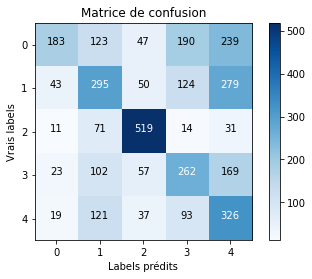



Classification report du modèle VGG19:

               precision    recall  f1-score   support

           0       0.23      0.66      0.34       279
           1       0.37      0.41      0.39       712
           2       0.80      0.73      0.77       710
           3       0.43      0.38      0.40       683
           4       0.55      0.31      0.40      1044

    accuracy                           0.46      3428
   macro avg       0.48      0.50      0.46      3428
weighted avg       0.51      0.46      0.47      3428



In [4]:
## Première étape, la matrice de confusion
cnf_matrix = confusion_matrix(y_test, y_pred)

### Display a nice confusion matrix
##
#
classes = range(0,(df['family'].nunique()))
print("Matrice de confusion issue du modèle VGG19:")
plt.figure()

plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
plt.title("Matrice de confusion")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment = "center",
             color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

plt.ylabel('Vrais labels')
plt.xlabel('Labels prédits')
plt.show()
#
##
###



## Seconde étape le classification report

print("\n\nClassification report du modèle VGG19:\n\n", classification_report(y_pred, y_test))

# Plot few images with their labels

<ipython-input-6-f637260b7e46>:8: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(cc,bb,i+1)


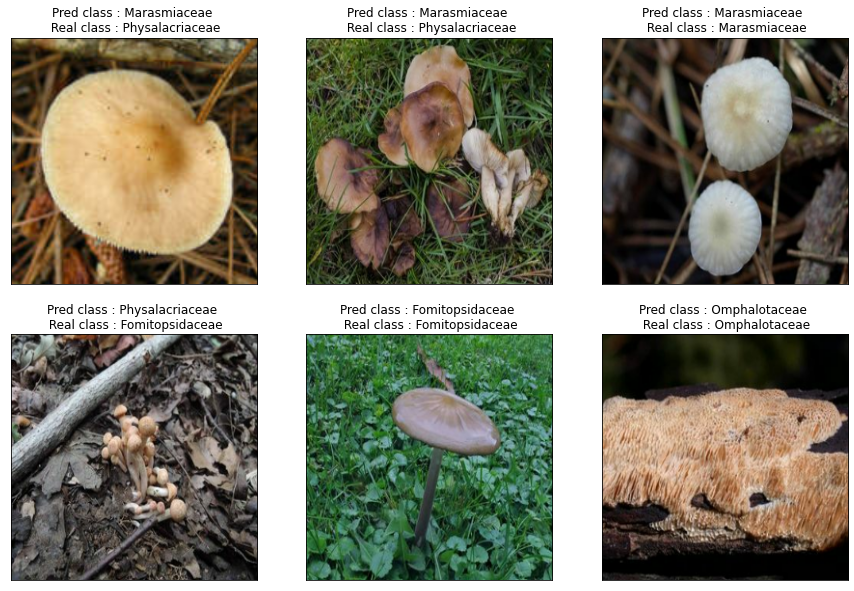

In [6]:
aa = 6 # number of total images to display
bb = 3 # number of colums !

indices_random = tf.random.uniform([aa], 0, len(X_test), dtype=tf.int32)
cc = aa/bb
plt.figure(figsize=(15,10))
for i, idx in enumerate(indices_random):
    plt.subplot(cc,bb,i+1)
    plt.imshow(tf.cast(X_test[idx], tf.int32))
    plt.xticks([])
    plt.yticks([])
    plt.title('Pred class : {} \n Real class : {}'.format(df.family.unique()[y_pred[idx]], df.family.unique()[y_test.values[idx]]))